# Time Series: Modeling

<hr style="border:2px solid blue"> </hr>


In [1]:
# Data Science Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# Additional Libraries
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# My functions
import wrangle

# Block Warning Messages
import warnings
warnings.filterwarnings("ignore")


# Using saas.csv or log data from API usage or store_item_sales



In [2]:
# Obtaining the data from my wrangle
df = wrangle.get_superstore()
df.head()

Checking if file exists...
Reading Data from file...


,item_id,sale_amount,sale_date,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013


In [3]:
# My prepared data didn't look right, so I'm just gonna use Ryan's prep code:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date, format = '%a, %d %b %Y %H:%M:%S %Z')).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

df.head()

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


In [4]:
# I still have the time of day on my index and it looks bad, so I'm going to simplify that real quick
# Creating a column for just the date
df['date'] = df.index.date
# Making sure that it's a datetime dtype
df['date'] = pd.to_datetime(df.date) 

df.head()

,dollars_sold,items_sold,date
ds,,,
2013-01-01 00:00:00+00:00,73844.01,13696.0,2013-01-01
2013-01-02 00:00:00+00:00,73570.58,13678.0,2013-01-02
2013-01-03 00:00:00+00:00,78169.48,14488.0,2013-01-03
2013-01-04 00:00:00+00:00,84467.73,15677.0,2013-01-04
2013-01-05 00:00:00+00:00,87621.85,16237.0,2013-01-05


In [5]:
# This dataframe looks much cleaner to work with for these exercises
df = df.set_index('date').sort_values('date')
df.head()

,dollars_sold,items_sold
date,,
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


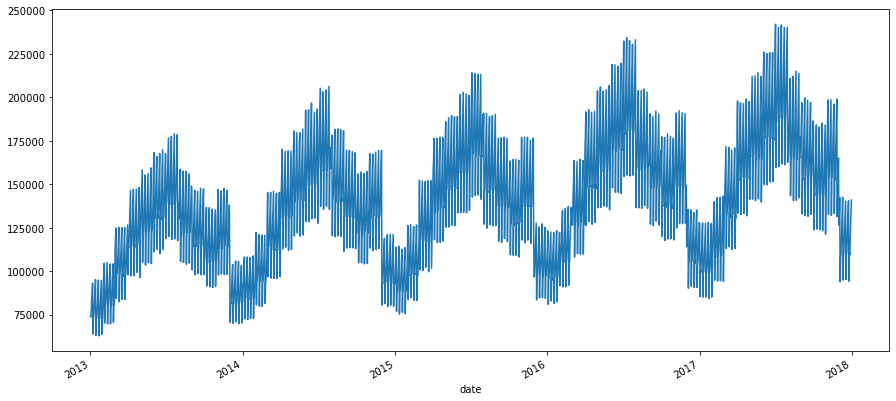

In [6]:
# Inspecting my dollars sold column
plt.figure(figsize=(15,7))
df.dollars_sold.plot();

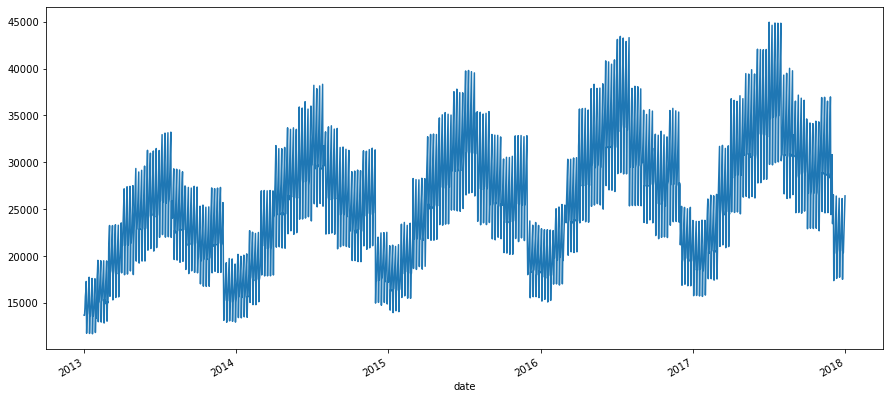

In [7]:
# Inspecting my items sold column
plt.figure(figsize=(15,7))
df.items_sold.plot();

### 1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.


In [8]:
# Define the size each dataframe needs to hold
# So train will hold the first half of the data, validate the next 30%, and test will be the last of what's left
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
# Calculating test based on train and validate
test_size = int(len(df) - train_size - validate_size)
# Defining where validate will stop in the index
validate_end_index = train_size + validate_size

# Now to actually split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [9]:
# Does validate start after train without gaps or overlap?
# Looks like it!
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
date,,
2016-12-30,120033.64,22296.0
2016-12-31,128009.31,23792.0


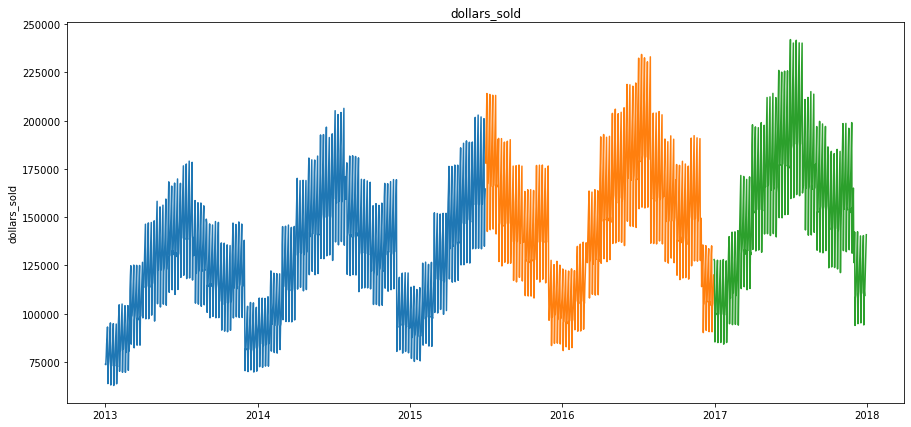

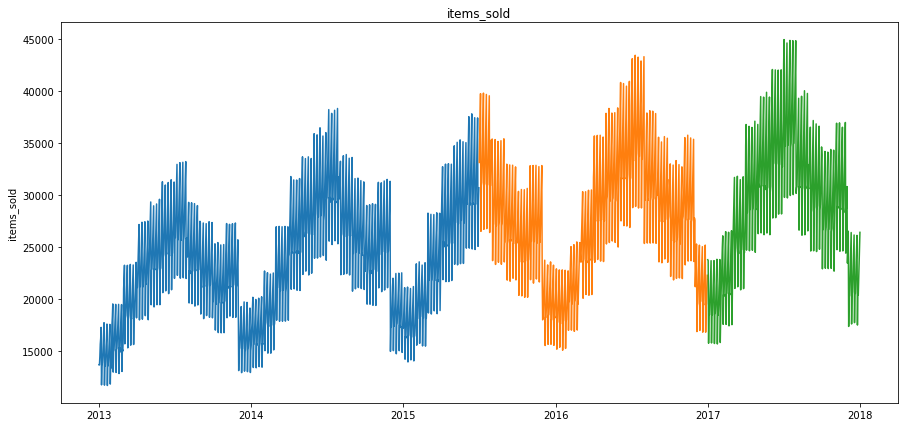

In [10]:
# Let's visualize the train, validate, test
# It's so pretty!
for col in train.columns:
    plt.figure(figsize=(15,7))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
 - Simple Average
 - Moving Average
 - Holt's Linear Trend Model
 - Based on previous year/month/etc., this is up to you.
 
But first, some functions to reuse:

In [11]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [12]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [13]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


#### Simple Average

In [14]:
# This model takes the simple average of historical values and uses 
# that value to predict future values.
# A straight lined prediction

items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

# Notice that all predictions will be the mean
yhat_df.head()

,items_sold,dollars_sold
date,,
2015-07-02,23717.94,127517.85
2015-07-03,23717.94,127517.85
2015-07-04,23717.94,127517.85
2015-07-05,23717.94,127517.85
2015-07-06,23717.94,127517.85


dollars_sold -- RMSE: 39664


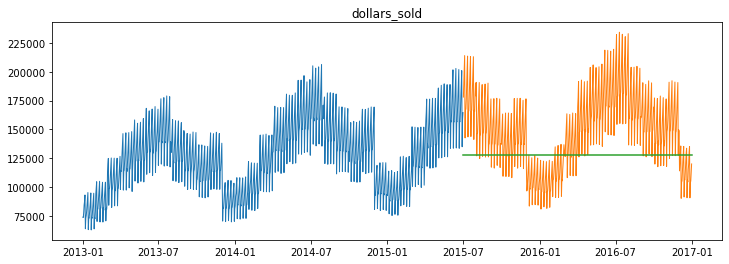

items_sold -- RMSE: 7378


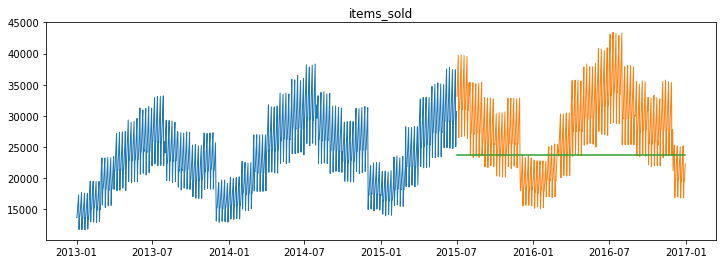

In [15]:
# Now to use that function above to see what it looks like visually
for col in train.columns:
    plot_and_eval(col)

In [16]:
# Next I'll add it to that dataframe created above so I can compare models
for col in train.columns:
    eval_df = append_eval_df(model_type='Simple Average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,Simple Average,dollars_sold,39664.0
1,Simple Average,items_sold,7378.0


#### Moving Average

In [17]:
# This model takes the average over the last 30-days and uses it
# as the forecasted value. So instead of the mean of all Train values
# it will just be the mean of the last 30-days.

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()

# Again, this just predicts a straight line trend based on mean
# So all predictions will just have that mean value
yhat_df.head()


,items_sold,dollars_sold
date,,
2015-07-02,31432.77,168957.91
2015-07-03,31432.77,168957.91
2015-07-04,31432.77,168957.91
2015-07-05,31432.77,168957.91
2015-07-06,31432.77,168957.91


dollars_sold -- RMSE: 37378


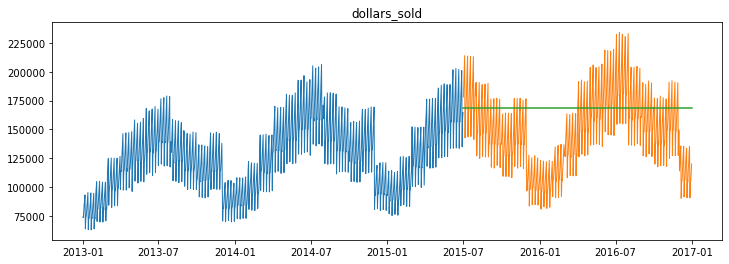

items_sold -- RMSE: 6954


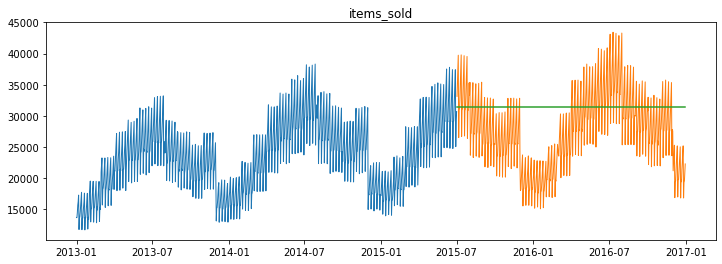

In [18]:
# Let's take a look at this line
for col in train.columns:
    plot_and_eval(col)

In [19]:
# Adding it to eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type='Moving Average 30-day', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,Simple Average,dollars_sold,39664.0
1,Simple Average,items_sold,7378.0
2,Moving Average 30-day,dollars_sold,37378.0
3,Moving Average 30-day,items_sold,6954.0


#### Holt's Linear Trend Model


In [20]:
# This model has Exponential smoothing applied to both the 
# average and the trend (slope).
# This is another straight lined model, but with a slope depending
# on the trend of previous data

for col in train.columns:
    # Make the thing
    model = Holt(train[col], exponential = False)
    # Fit the thing
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    # Use the thing
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

yhat_df.head()

,items_sold,dollars_sold
date,,
2015-07-02,31670.90,170251.51
2015-07-03,31660.56,170200.14
2015-07-04,31650.22,170148.77
2015-07-05,31639.88,170097.41
2015-07-06,31629.54,170046.04


dollars_sold -- RMSE: 34700


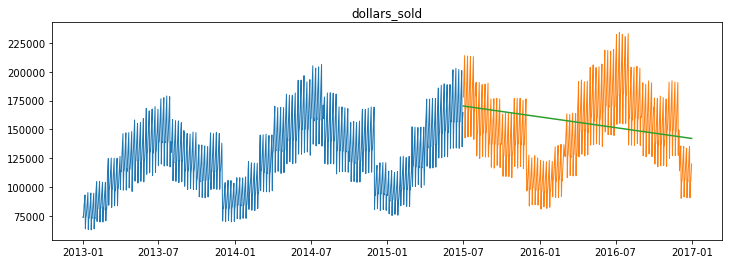

items_sold -- RMSE: 6464


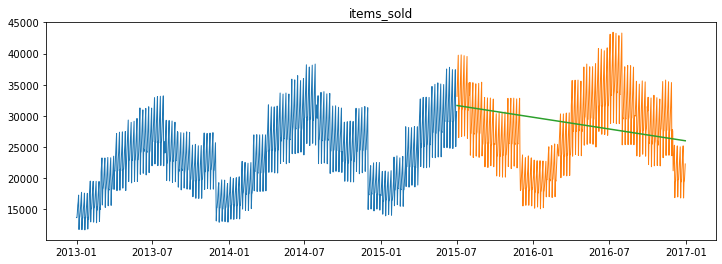

In [21]:
# Let's see waht this looks like
for col in train.columns:
    plot_and_eval(target_var = col)

So it predicts that there is a downward trend coming between 2015-07 and 2016-01 based on previous data. The weight of this trend is dependent on the values passed in `smoothing_level` and `smoothing_slope`.  

I could loop through several iterations of weights for these two, but maybe another time.

In [22]:
# Let's add it to the dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,Simple Average,dollars_sold,39664.0
1,Simple Average,items_sold,7378.0
2,Moving Average 30-day,dollars_sold,37378.0
3,Moving Average 30-day,items_sold,6954.0
4,Holts,dollars_sold,34700.0
5,Holts,items_sold,6464.0


#### Based on previous year/month/etc., this is up to you.

In [31]:
# Now for the FUN model! First I need to split the data in what
# I visually see as a trend cycle. For this data I see a yearly
# trend cycle.

train = df[:'2015']
validate = df['2016']
test = df['2017']

In [32]:
# Predictions
# The curriculum did one year, so to spice things up I'll see what
# half a year looks like :)
yhat_df = train['2015'] + train.diff(365).mean()

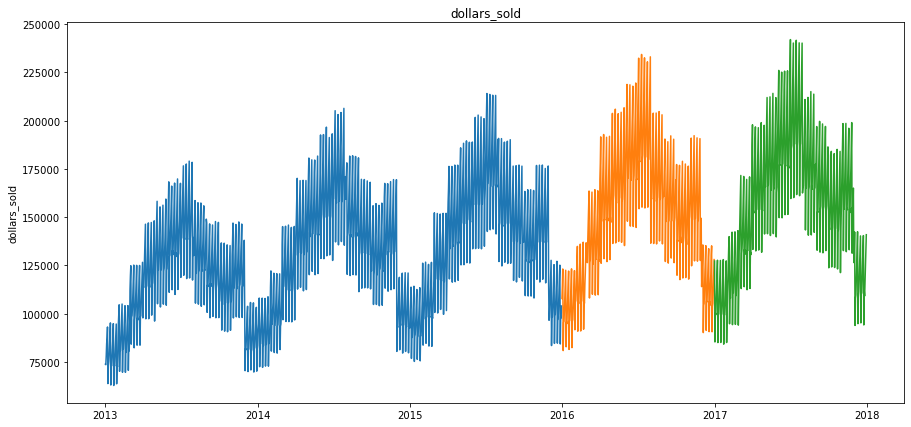

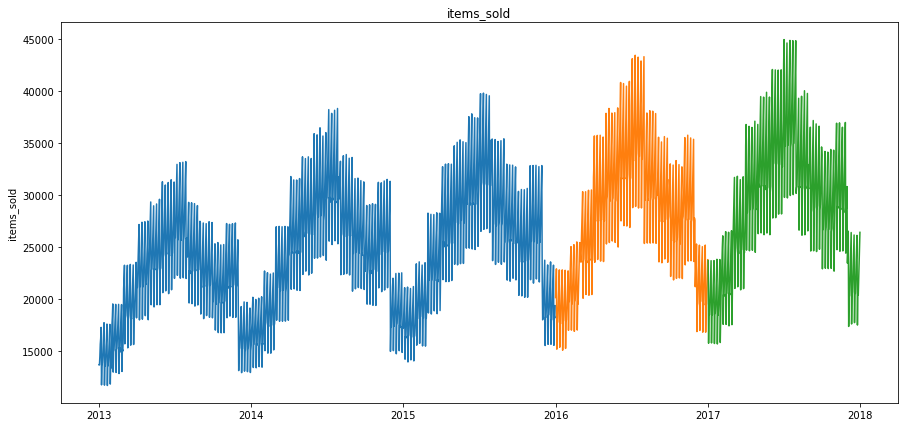

In [33]:
# Visualizing the split
for col in train.columns:
    plt.figure(figsize=(15,7))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [34]:
# Taking a look to make sure that dataframes are starting where I want them to
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
date,,
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [35]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

Process
1. Compute the 365 average year over year differences from 2013 through 2015 
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for.

dollars_sold -- RMSE: 28087


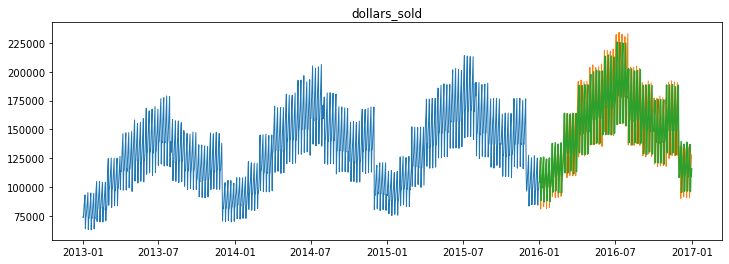

items_sold -- RMSE: 5223


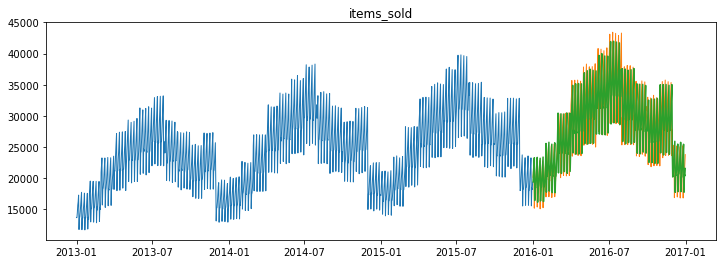

In [36]:
# Visualize
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

# The green is my prediction of Validate, and the orange is what Validate actually looked like.


# Optional: Using store item demand

### 1. Predict 2018 total monthly sales for a single store and/or item by creating a model.


### 2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).


### 3. Plot the 2018 monthly sales predictions.